In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [23]:
datagen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=False, rotation_range=30.0)

In [24]:
datagen_val = ImageDataGenerator(rescale=1./255)

In [25]:
train_gen = datagen_train.flow_from_directory('dogscats/train/',
                                        target_size = (197,197),
                                        batch_size = 256,
                                        shuffle = True,
                                       )

Found 23000 images belonging to 2 classes.


In [26]:
val_gen = datagen_val.flow_from_directory('dogscats/valid/',
                                      target_size = (197,197),
                                      batch_size = 256,
                                      shuffle = True,
                                       )

Found 2000 images belonging to 2 classes.


In [27]:
from matplotlib import pyplot as plt

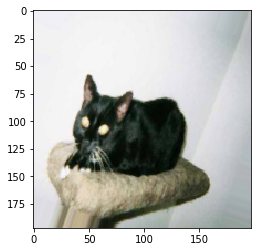

In [28]:
images_batch = next(train_gen)[0]
plt.imshow(images_batch[-1])
plt.show()

In [92]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

In [93]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, GlobalAveragePooling2D

In [94]:
inp = Input(shape=(197,197,3))

In [95]:
ResNet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(197,197,3))
ResNet50 = ResNet50_model(inp)

In [96]:
for layer in ResNet50_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdb30612e80> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fdb306127f0> True
<keras.layers.convolutional.Conv2D object at 0x7fdb30612e10> True
<keras.layers.normalization.BatchNormalization object at 0x7fdb306123c8> True
<keras.layers.core.Activation object at 0x7fdb30612198> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd7db5751d0> True
<keras.layers.convolutional.Conv2D object at 0x7fd7db5566a0> True
<keras.layers.normalization.BatchNormalization object at 0x7fdb305fb4a8> True
<keras.layers.core.Activation object at 0x7fdb306f8c88> True
<keras.layers.convolutional.Conv2D object at 0x7fdb3062fc18> True
<keras.layers.normalization.BatchNormalization object at 0x7fdb3072da58> True
<keras.layers.core.Activation object at 0x7fdb306084e0> True
<keras.layers.convolutional.Conv2D object at 0x7fdb30683860> True
<keras.layers.convolutional.Conv2D object at 0x7fdb305ca9e8> True
<keras.layers.normalization.BatchNormalizatio

In [97]:
for layer in ResNet50_model.layers:
    layer.trainable = False
    print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdb30612e80> input_6 False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fdb306127f0> conv1_pad False
<keras.layers.convolutional.Conv2D object at 0x7fdb30612e10> conv1 False
<keras.layers.normalization.BatchNormalization object at 0x7fdb306123c8> bn_conv1 False
<keras.layers.core.Activation object at 0x7fdb30612198> activation_99 False
<keras.layers.pooling.MaxPooling2D object at 0x7fd7db5751d0> max_pooling2d_3 False
<keras.layers.convolutional.Conv2D object at 0x7fd7db5566a0> res2a_branch2a False
<keras.layers.normalization.BatchNormalization object at 0x7fdb305fb4a8> bn2a_branch2a False
<keras.layers.core.Activation object at 0x7fdb306f8c88> activation_100 False
<keras.layers.convolutional.Conv2D object at 0x7fdb3062fc18> res2a_branch2b False
<keras.layers.normalization.BatchNormalization object at 0x7fdb3072da58> bn2a_branch2b False
<keras.layers.core.Activation object at 0x7fdb306084e0> activation_101 False
<keras.layers.c

In [98]:
ResNet50.shape.dims

[Dimension(None), Dimension(7), Dimension(7), Dimension(2048)]

In [99]:
GAP = GlobalAveragePooling2D()(ResNet50)
x = BatchNormalization()(GAP)
#x = Dense(100)(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
out = Dense(2, activation='softmax')(x)

In [100]:
model = Model(inp, out)

In [38]:
# model = ResNet50(include_top=False, weights='imagenet', input_shape=(197,197,3))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 8,194
Non-trainable params: 23,591,808
_________________________________________________________________


In [40]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
from fnn_helper import PlotLosses

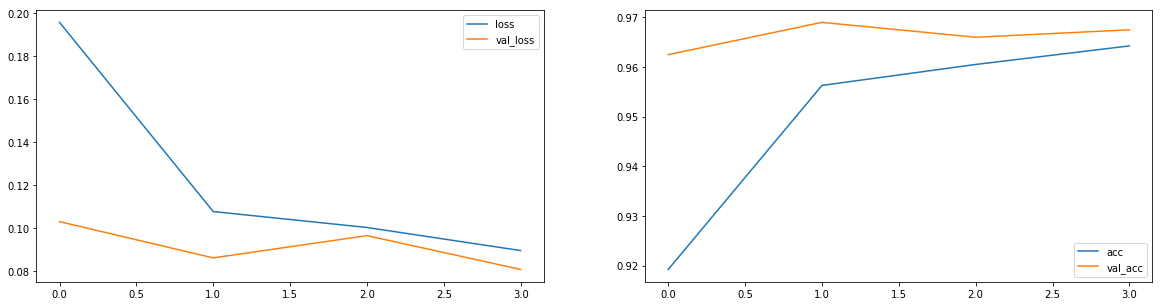

Epoch 5/100
 4/90 [>.............................] - ETA: 37s - loss: 0.0863 - acc: 0.9707

KeyboardInterrupt: 

In [42]:
model.fit_generator(train_gen,
          epochs=100,
            validation_data = val_gen,
            callbacks=[PlotLosses(1, evaluate_interval=None)])

In [101]:
#model.save_weights('resnet_50_keras_4_epochs.hdf5')

In [369]:
model.load_weights('resnet_50_keras_4_epochs.hdf5')

In [378]:
image = next(train_gen)[0][-1]

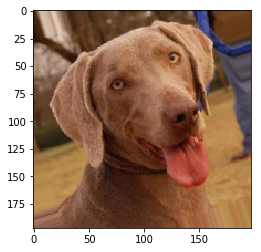

In [379]:
plt.imshow(image)
plt.show()

In [408]:
np.save('dog_sample', image)

In [457]:
image = np.load('3_cats_sample.npy')

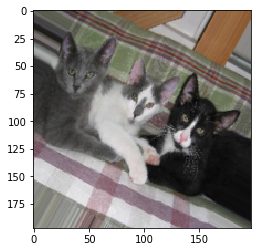

In [458]:
plt.imshow(image)
plt.show()

In [459]:
height, width , _ = image.shape

In [460]:
class_weights = model.layers[-1].get_weights()[0]

In [461]:
class_weights.shape

(2048, 2)

In [462]:
model.layers[-1].get_output_at(0)

<tf.Tensor 'dense_4/Softmax:0' shape=(?, 2) dtype=float32>

In [463]:
model_2 = Model(inp, [out, ResNet50])

In [464]:
prediction = model_2.predict(image.reshape(1, 197,197,3))

In [465]:
prediction[0].shape, prediction[1].shape

((1, 2), (1, 7, 7, 2048))

In [466]:
pred = np.argmax(prediction[0])
print(pred)

0


In [467]:
conv_outputs = prediction[1][0, :, :, :]

In [468]:
conv_outputs.shape

(7, 7, 2048)

In [469]:
import numpy as np
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[:2])
print(cam.shape)
#target_class = 1
#for i, w in enumerate(class_weights[:, target_class]):
#        cam += w * conv_outputs[i, :, :]

(7, 7)


In [470]:
train_gen.class_indices

{'cats': 0, 'dogs': 1}

In [471]:
target_class = pred
for i, w in enumerate(class_weights[:, target_class]):
    cam += w * conv_outputs[:, :, i]

In [472]:
cam.reshape(7, 7, 1).shape

(7, 7, 1)

In [473]:
cam

array([[ 3.2588813 ,  2.5069668 ,  2.029052  ,  1.1584777 ,  2.0975327 ,
         2.0769997 ,  0.23093298],
       [ 5.651491  ,  8.599263  ,  4.2450924 ,  1.4112824 , -0.1823841 ,
         0.09035648,  0.18912202],
       [ 8.450795  , 10.96591   ,  9.859242  ,  5.717906  ,  6.8985004 ,
         3.9189541 ,  1.1010092 ],
       [ 1.3067865 ,  4.970833  ,  2.2242215 ,  4.2434387 ,  8.541733  ,
         9.491918  ,  2.4275088 ],
       [ 0.6829981 ,  2.3551657 ,  1.0609764 ,  2.4089844 , 10.899148  ,
         7.3561387 ,  0.09323648],
       [-0.26507702, -0.16799317,  1.4943947 ,  2.6838422 ,  5.131202  ,
         3.5239654 ,  0.4505038 ],
       [-0.19415204, -0.39530605, -1.2149768 ,  0.12316349,  1.2282844 ,
         0.67316264,  1.3122005 ]], dtype=float32)

In [474]:
from skimage.transform import resize

In [475]:
im_max, im_min = np.max(cam), np.min(cam)

In [476]:
cam = (cam - im_min)/(im_max - im_min)

In [477]:
cam_resized = resize(cam, (197,197), anti_aliasing=0.15)

/home/usuario/anaconda3/envs/gpu/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


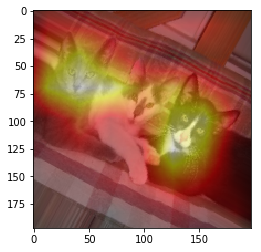

In [478]:
plt.imshow(image)
plt.imshow(cam_resized, cmap='hot', alpha=0.5)
plt.show()